<a href="https://colab.research.google.com/github/margolek/summer-practise-2021/blob/master/ROBOFLOW_tensorflow_object_detection_faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE: to obtain the most recent version of this notebook, please copy from 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1U3fkRu6-hwjk7wWIpg-iylL2u5T9t7rr#scrollTo=lsT4-_Eq45Ww)


## **Training Faster R-CNN Object Detection on a Custom Dataset**

### **Overview**

This notebook walks through how to train a Faster R-CNN object detection model using the TensorFlow Object Detection API.

In this specific example, we'll training an object detection model to recognize cells types: white blood cells, red blood cells and platelets. **To adapt this example to train on your own dataset, you only need to change two lines of code in this notebook.**

Everything in this notebook is also hosted on this [GitHub repo](https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn).

![Blood Cell Example](https://i.imgur.com/QwyX2aD.png)

**Credit to [DLology](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) and [Tony607](https://github.com/Tony607)**, whom wrote the first notebook on which much of this is example is based. 

### **Our Data**

We'll be using an open source cell dataset called BCCD (Blood Cell Count and Detection). Our dataset contains 364 images (and 4888 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/bccd).

When adapting this example to your own data, create two datasets in Roboflow: `train` and `test`. Use Roboflow to generate TFRecords for each, replace their URLs in this notebook, and you're able to train on your own custom dataset.

### **Our Model**

We'll be training a Faster R-CNN neural network. Faster R-CNN is a two-stage detector: first it identifies regions of interest, and then passes these regions to a convolutional neural network. The outputted features maps are passed to a support vector machine (SVM) for classification. Regression between predicted bounding boxes and ground truth bounding boxes are computed. (Consider [this](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a) deep dive for more!)

The model arechitecture is one of many available via TensorFlow's [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models).

### **Training**

Google Colab provides free GPU resources. Click "Runtime" → "Change runtime type" → Hardware Accelerator dropdown to "GPU."

Colab does have memory limitations, and notebooks must be open in your browser to run. Sessions automatically clear themselves after 12 hours.

### **Inference**

We'll run inference directly in this notebook, and on three test images contained in the "test" folder from our GitHub repo. 

When adapting to your own dataset, you'll need to add test images to the `test` folder located at `tensorflow-object-detection/test`.

### **About**

[Roboflow](https://roboflow.ai) makes managing, preprocessing, augmenting, and versioning datasets for computer vision seamless.

Developers reduce 50% of their boilerplate code when using Roboflow's workflow, automate labelling quality assurance, save training time, and increase model reproducibility.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)







In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%ls 

gdrive/  sample_data/


In [3]:
%cd gdrive/MyDrive/Programming/summer-practise-2021

/content/gdrive/MyDrive/Programming/summer-practise-2021


In [4]:
%cd Tensorflow_v1_color_aug_middle/

/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle


In [ ]:
!pip install tensorflow_gpu==1.15

## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [6]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 100000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 500

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [7]:
%pwd

'/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle'

## Clone the `tensorflow-object-detection` repository or your fork.

In [8]:
import os

%cd /content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.83 MiB | 15.55 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [9]:
%cd /content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/

/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle


In [10]:
%pwd

'/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle'

In [ ]:

!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib pycocotools tf_slim

%cd /content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/:/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/slim/'

!python object_detection/builders/model_builder_test.py

## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [17]:
%cd /content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data

/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data


In [20]:
# UPDATE THIS LINK - get our data from Roboflow
!curl -L "https://app.roboflow.com/ds/UFxXrbaMBB?key=ZKPKTa7m3p" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0    769      0  0:00:01  0:00:01 --:--:--   768
100 2766k  100 2766k    0     0  1700k      0  0:00:01  0:00:01 --:--:-- 1700k
Archive:  roboflow.zip
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/Hole.tfrecord      
 extracting: test/Hole_label_map.pbtxt  
replace train/Hole.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: train/Hole.tfrecord     
replace train/Hole_label_map.pbtxt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: train/Hole_label_map.pbtxt  
   creating: valid/
 extracting: valid/Hole.tfrecord     
 extracting: valid/Hole_label_map.pbtxt  


In [21]:
%ls

FYI.txt  README.roboflow.txt  test/  train/  valid/


In [22]:
# check out what we have in train
%ls train

Hole_label_map.pbtxt  Hole.tfrecord


In [23]:
# show what we have in test
%ls test

Hole_label_map.pbtxt  Hole.tfrecord


In [24]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data/valid/Hole.tfrecord'
train_record_fname = '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data/train/Hole.tfrecord'
label_map_pbtxt_fname = '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data/train/Hole_label_map.pbtxt'

## Download base model

In [25]:
%cd /content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

In [27]:
# #RUN ONLY DURING 1ST TRAINING!!
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/pretrained_model/model.ckpt'

In [ ]:
#THIS SCRIPT RESTORE MODEL THE LATEST MODEL CHECKPOINT
THE_LATEST_CHECKPOINT = '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/training'
#PUT CHECKPOINT NUMBER IN PLACE '.....'
fine_tune_checkpoint = os.path.join(THE_LATEST_CHECKPOINT, "model.ckpt-10378")
fine_tune_checkpoint

'/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1/models/research/training/model.ckpt-10378'

## Configuring a Training Pipeline

In [28]:
import os
pipeline_fname = os.path.join('/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [29]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [30]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

In [32]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [36]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-07-26 07:20:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.192.135.96, 52.45.195.11, 3.215.21.243, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.192.135.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  11.9MB/s    in 1.1s    

2021-07-26 07:20:46 (11.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [37]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [38]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [39]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://aae175661280.ngrok.io


## Train the model

In [ ]:
!pip install lvis

In [34]:
!python /content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Traceback (most recent call last):
  File "/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/object_detection/model_main.py", line 108, in <module>
    tf.app.run()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/object_detection/model_main.py", line 104, in main
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_specs[0])
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/training.py", line 473, in train_and_evaluate
    return executor.run

In [35]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1627253515.7f56d444a059
graph.pbtxt
model.ckpt-62582.data-00000-of-00001
model.ckpt-62582.index
model.ckpt-62582.meta
model.ckpt-63941.data-00000-of-00001
model.ckpt-63941.index
model.ckpt-63941.meta
model.ckpt-65301.data-00000-of-00001
model.ckpt-65301.index
model.ckpt-65301.meta
model.ckpt-66660.data-00000-of-00001
model.ckpt-66660.index
model.ckpt-66660.meta
model.ckpt-68018.data-00000-of-00001
model.ckpt-68018.index
model.ckpt-68018.meta


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [40]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-68018
Instructions for updating:
Please use `layer.__call__` method instead.
W0726 07:24:49.291824 139947388876672 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Scale of 0 disables regularizer.
I0726 07:24:50.563526 139947388876672 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I0726 07:24:50.684832 139947388876672 regularizers.py:99] Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0726 07:24:50.685219 139947388876672 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0726 07:24:50.741855

In [41]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [42]:
import os

output_directory = '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/fine_tuned_model'
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [43]:
!ls -alh {pb_fname}

-rw------- 1 root root 50M Jul 26 07:24 /content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=XmuAbEshuMer9xCPk8IShCVSOxSBZSZjsZsyOSvpSDs&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive

Enter verification code: ··········


AuthorizationError: ignored

### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
from google.colab import files
files.download(pb_fname)

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
from google.colab import files
files.download(label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
files.download(pipeline_fname)

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test

To test on your own images, you need to upload raw test images to the `test` folder located inside `/data`.

Right now, this folder contains TFRecord files from Roboflow. We need the raw images.


#### Add test images to this notebook

We can download the exact same raw images that are in our Roboflow test split to our local computer by downloading the images in a different (non-TFRecord) format.

Go back to our [dataset](https://public.roboflow.ai/object-detection/bccd/1), click "Download," select "COCO JSON" as the format, and download to your local machine.

Unzip the downloaded file, and navigate to the `test` directory.
![folder](https://i.imgur.com/xkjxmKP.png)


Now, on the left-hand side in the colab notebook, select the folder icon.
![Colab folder](https://i.imgur.com/59v08qG.png)

Right-click on `test`, and select "Upload." Navigate to the files locally on your machine you just downloaded...and voila! You're set!


In [44]:
# optionally, remove the TFRecord and cells_label_map.pbtxt from
# the test directory so it is only raw images
%cd {repo_dir_path}
%cd data/test
%rm Hole.tfrecord
%rm Hole_label_map.pbtxt

/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn
/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data/test


In [79]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/test",)

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)

TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data/test/hole.00f917de-ed4f-11eb-acc2-3cf01128050e.jpg', '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data/test/hole.0b62ff46-ed4f-11eb-b91d-3cf01128050e.jpg', '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data/test/hole.0ac5faec-ed4f-11eb-9dcd-3cf01128050e.jpg', '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data/test/hole.31ea1976-ede6-11eb-b348-3cf01128050e.jpg', '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/tensorflow-object-detection-faster-rcnn/data/test/hole.c86ac028-ede6-11eb-8665-3cf01128050e.jpg', '/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensor

In [80]:
%cd /content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/gdrive/MyDrive/Programming/summer-practise-2021/Tensorflow_v1_color_aug_middle/models/research/object_detection


In [81]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  channel_dict = {'L':1, 'RGB':3} # 'L' for Grayscale, 'RGB' : for 3 channel images
  return np.array(image.getdata()).reshape(
      (im_height, im_width, channel_dict[image.mode])).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [82]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline
import time

--- 1.104663372039795 seconds ---
2
--- 1.1541955471038818 seconds ---
2
--- 1.0936839580535889 seconds ---
2
--- 1.1181480884552002 seconds ---
0
--- 1.1270124912261963 seconds ---
0
--- 1.1314003467559814 seconds ---
1
--- 1.1417145729064941 seconds ---
0


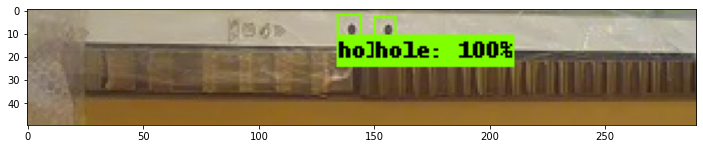

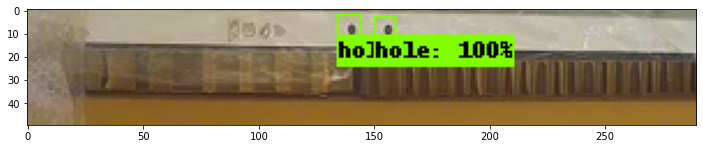

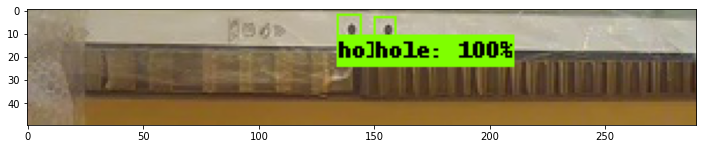

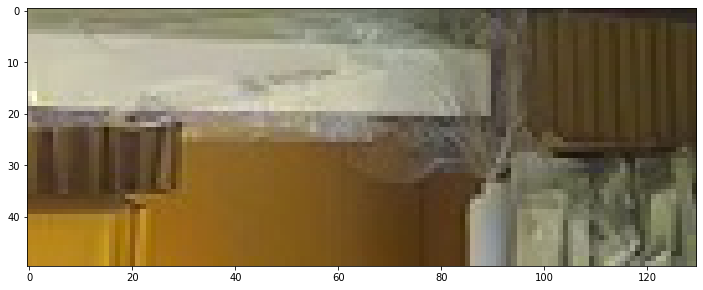

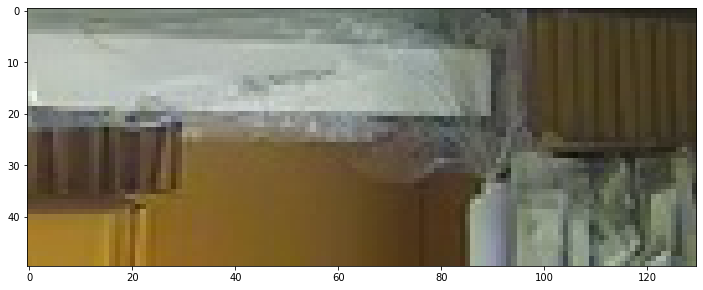

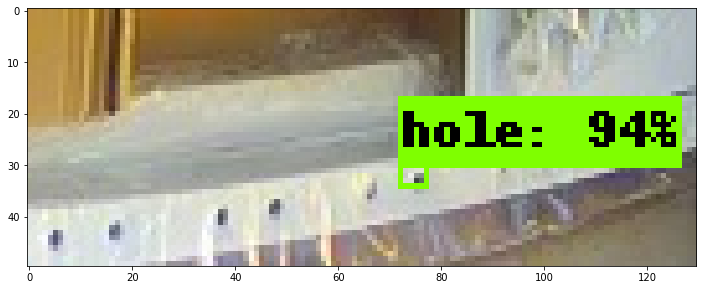

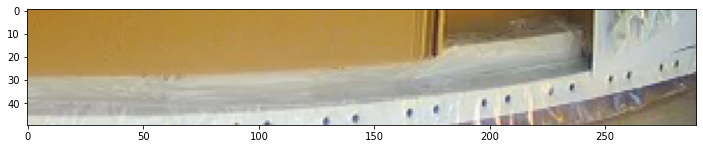

In [83]:

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    if image_np.shape[2] != 3:  
        image_np = np.broadcast_to(image_np, (image_np.shape[0], image_np.shape[1], 3)).copy() # Duplicating the Content
        ## adding Zeros to other Channels
        ## This adds Red Color stuff in background -- not recommended 
        # z = np.zeros(image_np.shape[:-1] + (2,), dtype=image_np.dtype)
        # image_np = np.concatenate((image_np, z), axis=-1)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Actual detection.
    start_time = time.time()
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    print("--- {} seconds ---".format(time.time() - start_time))
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        min_score_thresh=.7,
        line_thickness=1)
    x = output_dict['detection_scores']
    print(len(x[x>0.9]))
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)